Time series prediction is more complicated than I originally anticipated when I tackled the subject during my thesis - while you can treat the events independently, like geographic data, *everything* is related: what happened yesterday will affect what happened today, and a Friday in July is not the same as a Monday in October.
<!-- TEASER_END -->


There are various weird and wonderful algorithms to cope with these complexities, but Facebook's open source Prophet does a fantastic job of providing a "fire and forget" solution that just *works*.  

This is the code extract from [my Medium blog here](https://towardsdatascience.com/predicting-police-call-demand-for-fun-and-prophet-2e278828a1a1).

In [2]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
#import chart_studio


## Data Cleaning and Aggregating
We'll be using four years of LAPD call data, aggregated to hourly intervals.  Prophet actually copes with various intervals quite well, so don't worry too much about how you do yours: just try and keep regular intervals, without too many missings bits.

In [3]:
df_by_hour = pd.read_csv("/content/total_calls_per_hour.csv")

In [4]:
df_by_hour["ds"] = pd.date_range(min(df_by_hour["ds"]), max(df_by_hour["ds"]), freq='H')

Your final cleaned data-set must contain the below two columns, ds and y.  Everything else, Prophet will deal with.

In [5]:
df_by_hour.head()

Dispatch Date_Dispatch Time  call volume                  ds    y
0         2015-01-01 00:00:00          286 2015-01-01 00:00:00  286
1         2015-01-01 01:00:00          265 2015-01-01 01:00:00  265
2         2015-01-01 02:00:00          179 2015-01-01 02:00:00  179
3         2015-01-01 03:00:00          152 2015-01-01 03:00:00  152
4         2015-01-01 04:00:00          127 2015-01-01 04:00:00  127

In [6]:
df_by_hour.tail()


Dispatch Date_Dispatch Time  call volume                  ds    y
43819         2019-12-31 19:00:00          310 2019-12-31 19:00:00  310
43820         2019-12-31 20:00:00          320 2019-12-31 20:00:00  320
43821         2019-12-31 21:00:00          373 2019-12-31 21:00:00  373
43822         2019-12-31 22:00:00          354 2019-12-31 22:00:00  354
43823         2019-12-31 23:00:00          281 2019-12-31 23:00:00  281

##Fitting and Deploying
Prophet works similar to most Python sklearn type implementations - just fit the data and you're off.

Helpfully, it will also make you a data-frame containing future dates for you to predict on.  It will also provide a breakdown of seasonality trends.

In [7]:
m = Prophet()
m.fit(df_by_hour)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [8]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

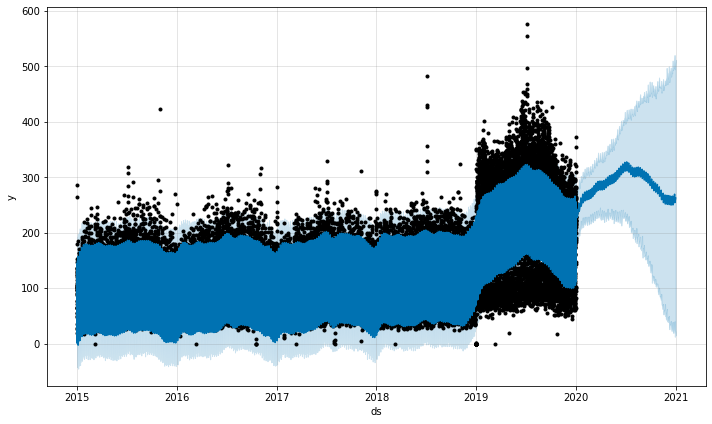

In [9]:
fig1 = m.plot(forecast)

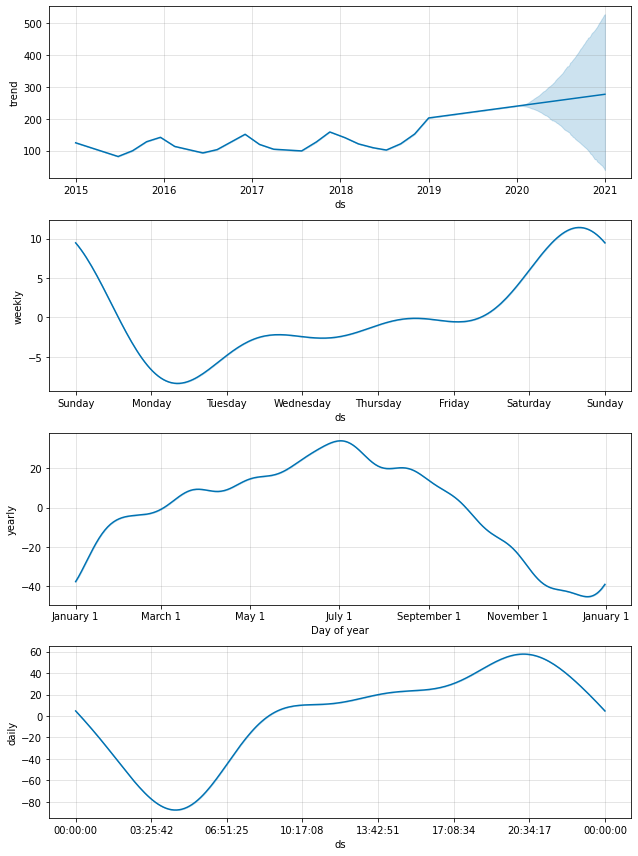

In [10]:
fig2 = m.plot_components(forecast)


In [13]:

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
fig.show()


## Diagnostics and Cross Validation
Helpfully, Prophet also contains cross-validation functionality - and performs quite well, very quickly!

In [14]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-10 23:00:00 and 2018-12-31 23:00:00


ds        yhat  ...   y              cutoff
0 2017-01-11 00:00:00  116.692077  ...  79 2017-01-10 23:00:00
1 2017-01-11 01:00:00   95.572727  ...  71 2017-01-10 23:00:00
2 2017-01-11 02:00:00   71.996010  ...  55 2017-01-10 23:00:00
3 2017-01-11 03:00:00   49.332357  ...  51 2017-01-10 23:00:00
4 2017-01-11 04:00:00   33.137479  ...  41 2017-01-10 23:00:00

[5 rows x 6 columns]

In [15]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


horizon          mse       rmse        mae     mdape  coverage
0 36 days 12:00:00  2938.141411  54.204625  33.287400  0.167800  0.660046
1 36 days 13:00:00  2929.579619  54.125591  33.235735  0.167594  0.660731
2 36 days 14:00:00  2919.565265  54.033002  33.187913  0.167276  0.660959
3 36 days 15:00:00  2908.693562  53.932305  33.155190  0.166688  0.661187
4 36 days 16:00:00  2910.565179  53.949654  33.167673  0.166688  0.660959

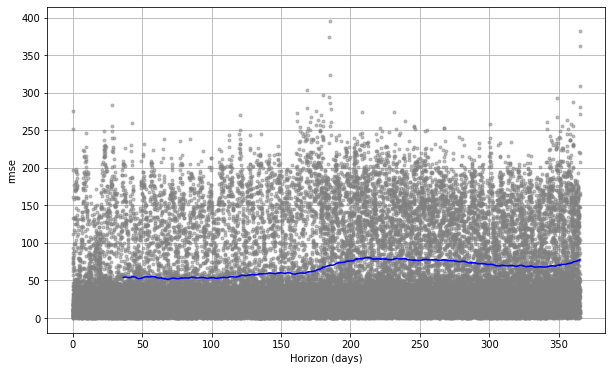

In [16]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')
